## 1 Inicializacion

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns


### 1.1 Carga de datos

In [4]:
games_df=pd.read_csv('/datasets/games.csv')

## 2 Preparar los datos

In [6]:
#Revisamos la info del DataFrame
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
## Minusculas en las columnas
games_df.columns=games_df.columns.str.lower()

## Eliminiar nombres que sean Nan (Complica el analisis al no poder determinar de que juego estamos hablando)
games_df=games_df.dropna(subset=['name'])

## Minusculas para los nombres y genero
games_df['name']=games_df['name'].str.lower()
games_df['genre']=games_df['genre'].str.lower()


#Si algún videojuego existe para varias plataformas y no tiene 'year_of_release'. Se le pone el de otra plataforma, 
#ya que es muy probable que hayan salido en el mismo año.
games_df['year_of_release']=games_df.groupby('name')['year_of_release'].transform(lambda x:x.bfill().ffill())

#la columna 'year_of_release' aun tiene valores ausentes, asi que se usará el año promedio que le corresponde segun los juegos lanzados
#para la plataforma que es.
#Primero sacaremos el año promedio de cada plataforma
console_year_median=games_df.groupby('platform')['year_of_release'].agg(['min','max']).astype('Int64')
#reemplazaremos el valor minimo de la plataforma DS,3DS,GB y GBA ya que es imposible que haya juegos antes del lanzamiento de la misma plataforma
console_year_median.loc['DS','min']=2004
console_year_median.loc['3DS','min']=2011
console_year_median.loc['GB','min']=1989
console_year_median.loc['GBA','min']=2001
console_year_median.loc['PS3','min']=2006
console_year_median.loc['XB','min']=2001

console_year_median['median_year']=console_year_median.median(axis=1).astype('Int64')
#print(console_year_mean)

#Reemplazaremos a los juegos que tengan el año anterior a la fecha de lanzamiento de la plataforma para que en futuros analisis no nos afecte.
games_df.loc[(games_df['platform']=='DS')&(games_df['year_of_release']<2004),'year_of_release']=console_year_median.loc['DS','median_year']
games_df.loc[(games_df['platform']=='3DS')&(games_df['year_of_release']<2011),'year_of_release']=console_year_median.loc['3DS','median_year']
games_df.loc[(games_df['platform']=='GB')&(games_df['year_of_release']<1989),'year_of_release']=console_year_median.loc['GB','median_year']
games_df.loc[(games_df['platform']=='GBA')&(games_df['year_of_release']<2001),'year_of_release']=console_year_median.loc['GBA','median_year']
games_df.loc[(games_df['platform']=='PS3')&(games_df['year_of_release']<2006),'year_of_release']=console_year_median.loc['PS3','median_year']
games_df.loc[(games_df['platform']=='XB')&(games_df['year_of_release']<2001),'year_of_release']=console_year_median.loc['XB','median_year']



#Aqui reemplazamo el valor ausente con el año promedio según la plataforma y cambiamos el tipo de dato a Int64
games_df['year_of_release']=games_df['year_of_release'].fillna(games_df['platform'].map(console_year_median['median_year'])).astype('Int64')
#games_df['year_of_release'].astype('Int64')

#La plataforma DS tiene videojuegos lanzados antes del lanzamiento de la plataforma misma, lo que es imposible. 
#Reemplazaremos éstos con el año promedio calculado anteriormente


In [8]:
console_year_median.head(15)

,min,max,median_year
platform,,,
2600,1980,1994,1987
3DO,1994,1995,1994
3DS,2011,2016,2013
DC,1998,2008,2003
DS,2004,2013,2008
GB,1989,2001,1995
GBA,2001,2007,2004
GC,2001,2007,2004
GEN,1990,1994,1992


In [9]:
#La columna critic score la pasaremos a tipo Int64 ya que no necesitamos de decimales.
games_df['critic_score']=games_df['critic_score'].astype('Int64')

#La columna 'user_score' le reemplazaremos los string 'tbd' por NaN para poder cambiar la columna a tipo float y poder hacer operaciones en ella.
games_df['user_score']=games_df['user_score'].replace('tbd',np.nan)
games_df['user_score']=games_df['user_score'].astype(float)

#La columna rating reemplazaremos los valores NaN por el str 'Unknown' para poder catergorizar mejor.
games_df['rating']=games_df['rating'].fillna('Unknown')

#Agregamos una nueva columna con el numero total de ventas de todas las regiones.
games_df['total_sales']=games_df['na_sales']+games_df['eu_sales']+games_df['jp_sales']+games_df['other_sales']


In [10]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.7+ MB


In [11]:
games_df.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15581,you don't know jack,PC,1995,misc,0.02,0.00,0.00,0.00,<NA>,NaN,Unknown,0.02
691,warioware touched!,DS,2004,puzzle,0.51,0.45,1.21,0.13,<NA>,NaN,Unknown,2.30
14176,boboboubo boubobo: ougi 87.5 bakuretsu hanage ...,GBA,2002,action,0.00,0.00,0.03,0.00,<NA>,NaN,Unknown,0.03
7402,danganronpa another episode: ultra despair girls,PSV,2014,action,0.06,0.01,0.12,0.02,72,8.4,M,0.21
13981,jikkyou powerful major league,GC,2006,sports,0.00,0.00,0.04,0.00,<NA>,NaN,Unknown,0.04
7058,lunar knights,DS,2006,role-playing,0.17,0.01,0.04,0.01,82,7.8,E10+,0.23
12925,batman: a telltale game series,PS3,2016,adventure,0.01,0.04,0.00,0.01,<NA>,NaN,Unknown,0.06
2366,monster 4x4: world circuit,Wii,2006,racing,0.80,0.00,0.01,0.07,51,7.8,E,0.88
7062,wwe all stars,3DS,2011,fighting,0.15,0.06,0.00,0.02,71,7.4,T,0.23
3083,animaniacs ten pin alley,PS,1998,sports,0.36,0.25,0.00,0.04,<NA>,NaN,Unknown,0.65


## 3 Análisis de datos

### 3.1 Ventas de juegos por año

In [14]:
print (games_df.groupby('year_of_release')['year_of_release'].count())

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      13
1986      21
1987      32
1988      14
1989      17
1990      16
1991      41
1992      43
1993      60
1994     122
1995     221
1996     263
1997     289
1998     386
1999     339
2000     353
2001     484
2002     845
2003     785
2004     786
2005     967
2006    1020
2007    1202
2008    1463
2009    1437
2010    1281
2011    1184
2012     662
2013     555
2014     582
2015     606
2016     502
Name: year_of_release, dtype: Int64


La venta de videojuegos si varia de año a año. Siendo los años de 2006 a 2011 donde hay más de mil juegos. Y el 2008 cuando más juegos se han lanzado.

### 3.2 Ventas por plataforma

<function matplotlib.pyplot.show(close=None, block=None)>

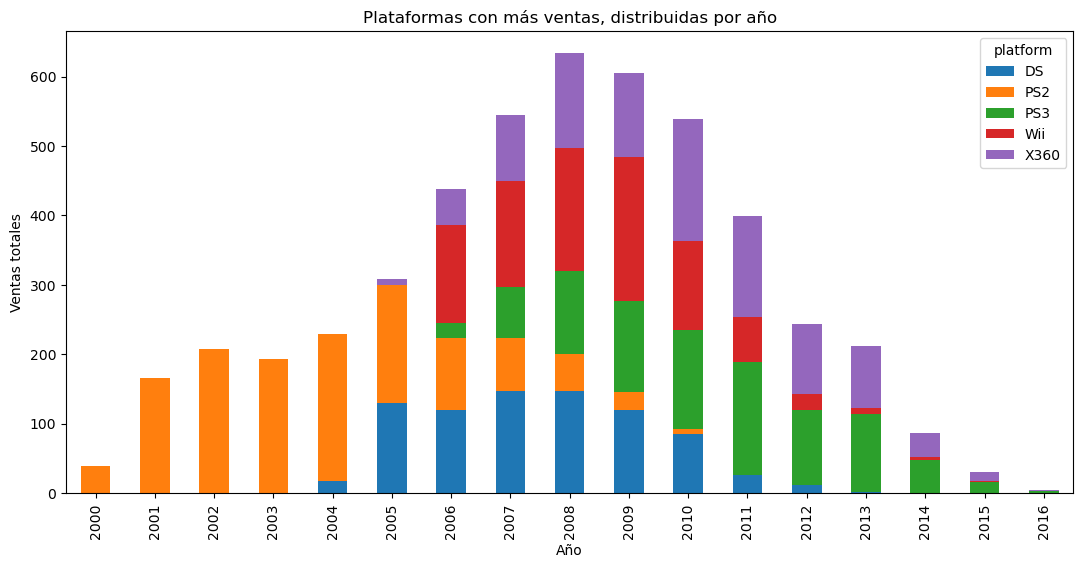

In [17]:
platform_sales_df=games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
top_platforms=platform_sales_df.head(5).index
games_top_df=games_df[games_df['platform'].isin(top_platforms)]
yearly_top_games_df=games_top_df.groupby(['year_of_release','platform'])['total_sales'].sum().unstack(level=1)
yearly_top_games_df.plot(kind='bar', title='Plataformas con más ventas, distribuidas por año',xlabel='Año', ylabel='Ventas totales', stacked=True,figsize=(13,6))
plt.show

A partir de esta gráfica podemos observar que el 2008 es donde podemos llegar a tomar varios datos, ya que es el que más muestras tiene.

El promedio de vida de una plataforma es de: 7.129032258064516


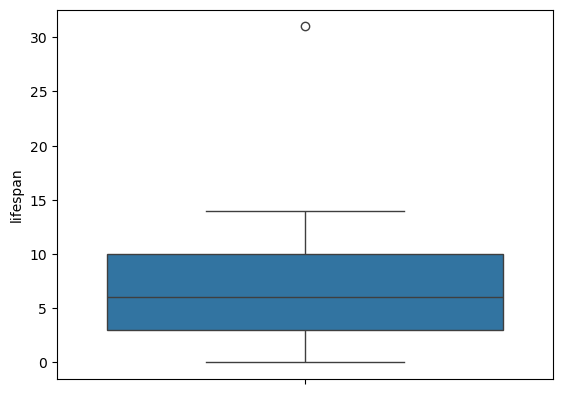

In [19]:
# Vamos a determinar los años promedio de vida de las plataformas, usando un dataframe anterior
#console_year_median=games_df.groupby('platform')['year_of_release'].agg(['min','max']).astype('Int64')
console_year_median['lifespan']=console_year_median['max']-console_year_median['min']
#console_year_median.reset_index(inplace=True)
#console_year_median.head(50)
lifespan_mean=console_year_median['lifespan'].mean()
print (f'El promedio de vida de una plataforma es de: {lifespan_mean}')
sns.boxplot(console_year_median['lifespan'])
plt.show()

Tomando en cuenta que el promedio de vida de cada plataforma es de 7 años, podriamos asumir que a la mitad de su vida es cuando más ventas genera, podriamos revisar que consolas están en su mejor momento haciendo un calculo de ventas del 2013 al 2106. Esto nos puede ayudar para ver cuales son las consolas que van en crecimiento.

<function matplotlib.pyplot.show(close=None, block=None)>

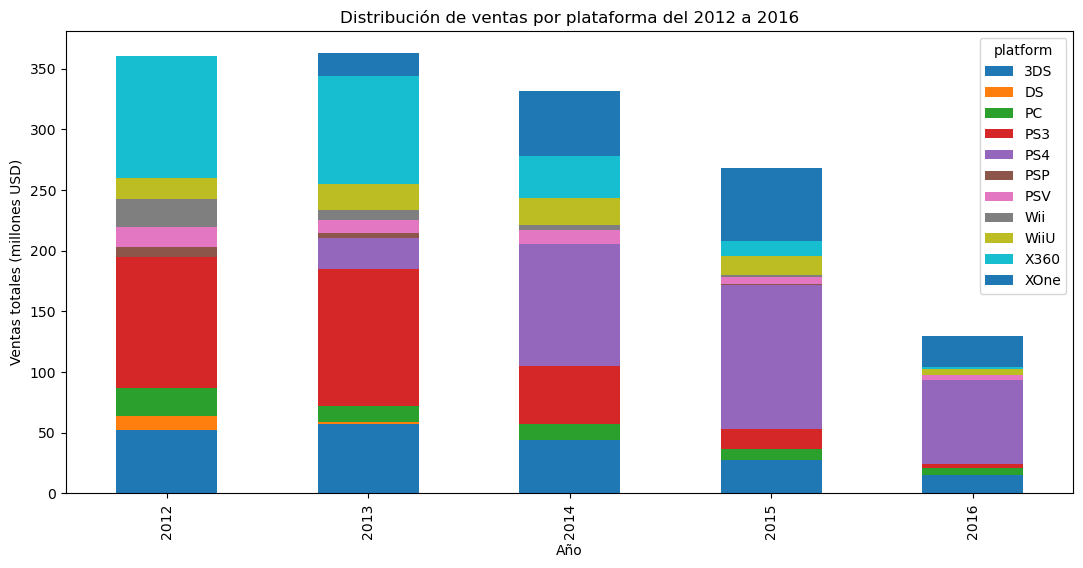

In [21]:
latest_games_df=games_df[games_df['year_of_release']>=2012]
sales_late_games_df=latest_games_df.groupby(['year_of_release','platform'])['total_sales'].sum().unstack(level=1)
sales_late_games_df.plot(kind='bar', title='Distribución de ventas por plataforma del 2012 a 2016',xlabel='Año', ylabel='Ventas totales (millones USD)', stacked=True,figsize=(13,6))
plt.show

En esta gráfica podemos ver que algunas plataformas ya van bajando sus ventas, tomando en cuenta que ya van a cumplir su tiempo de vida, no las tomaremos en cuenta para futuras publicidades. Mejor ponemos atención a las plataformas que van en crecimiento o que representan una venta considerable. Éstas plataformas serian el PS4 siendo la de mayor crecimiento. Tomaremos en cuenta tambien al Xone,3DS y WiiU al ser los siguientes en ventas.

Despues de analizar los datos, podemos tomar la decision de tomar los datos del año 2015, ya que se ve una tendencia de crecimiento de la plataforma PS4 y 3DS, ademas que los datos de 2016 no se encuentran completos.

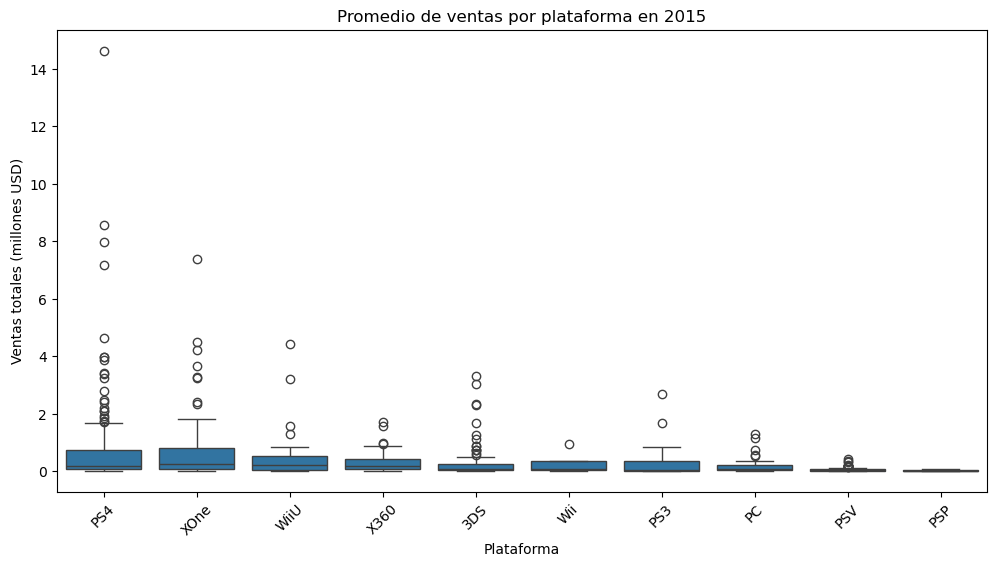

In [24]:
games_15_df=games_df[games_df['year_of_release']==2015]
games_15_mean_df=games_15_df.groupby('platform')['total_sales'].mean().sort_values(ascending=False)
ordered_games_15_df=games_15_mean_df.index.tolist()
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)
sns.boxplot(x='platform',y='total_sales',data=games_15_df,order=ordered_games_15_df)
plt.xlabel('Plataforma')
plt.ylabel('Ventas totales (millones USD)')
plt.title('Promedio de ventas por plataforma en 2015')
plt.show()

In [25]:
games_15_mean_df.head(15)

platform
PS4     0.867883
XOne    0.751750
WiiU    0.583929
X360    0.341714
3DS     0.323023
Wii     0.285000
PS3     0.230411
PC      0.170400
PSV     0.056818
PSP     0.040000
Name: total_sales, dtype: float64

Analizando los diagramas de caja podemos ver que el PS4 es el que más ventas tiene en promedio, sin embargo su diferencia no es considerable en comparación del XOne, WiiU y otros. Pero tambien podemos ver que hay más juegos de PS4 que se salen de la gráfica. Tal vez ciertos juegos en especifico vale la pena ponerles más publicidad.


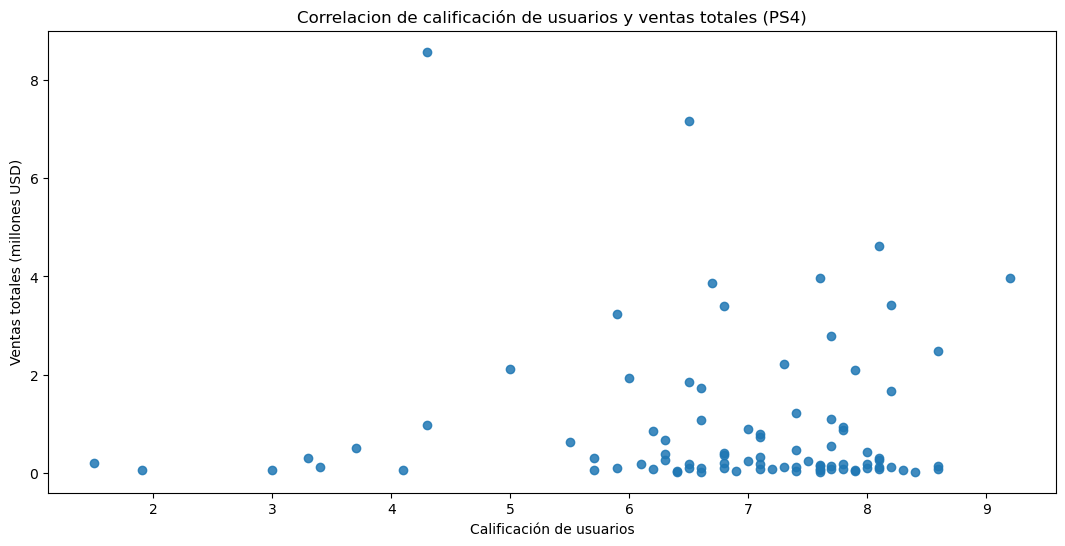

In [27]:
#Revisaremos la correlacion que tienen las calificaciones de los usuario y de los críticos con las ventas totales.

games_15_ps4_df=games_15_df[games_15_df['platform']=='PS4']
games_15_ps4_df.plot(x='user_score',y='total_sales',title='Correlacion de calificación de usuarios y ventas totales (PS4)',style='o',
                    xlabel='Calificación de usuarios',ylabel='Ventas totales (millones USD)',alpha=0.85,figsize=(13,6))
plt.legend().remove()
#sns.scatterplot(x='user_score',y='total_sales',data=games_15_ps4_df)

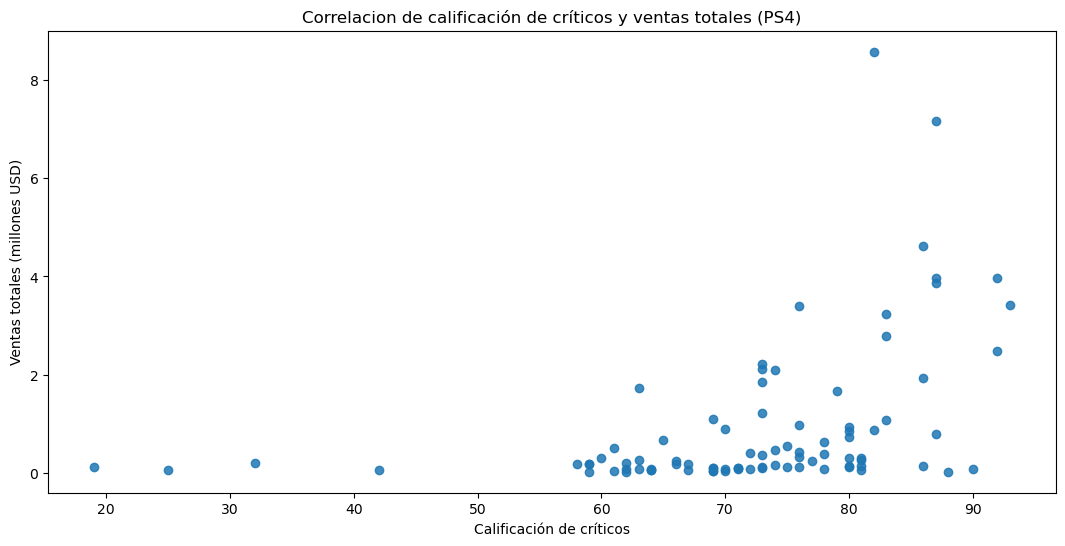

In [28]:
drop_g_15_ps4_df=games_15_ps4_df.dropna(subset=['critic_score'])
drop_g_15_ps4_df.plot(x='critic_score',y='total_sales',title='Correlacion de calificación de críticos y ventas totales (PS4)',style='o',
                    xlabel='Calificación de críticos',ylabel='Ventas totales (millones USD)',alpha=0.85,figsize=(13,6))
plt.legend().remove()

In [29]:
corr_user=games_15_ps4_df['user_score'].corr(games_15_ps4_df['total_sales'])
corr_critic=drop_g_15_ps4_df['critic_score'].corr(games_15_ps4_df['total_sales'])

print(f'La correlacion entre la calificación de los usuarios y las ventas totales es de: {corr_user}')
print(f'La correlacion entre la calificación de los críticos y las ventas totales es de: {corr_critic}')

La correlacion entre la calificación de los usuarios y las ventas totales es de: -0.002308450810856224
La correlacion entre la calificación de los críticos y las ventas totales es de: 0.4123418699511164


Al ver las gráficas de dispersión notamos que las calificaciones de los críticos influencian las ventas mientras que si los usuarios lo califican bien, no se refleja en las ventas.

In [31]:
#Ahora revisaremos como son las ventas de los juegos que son multiplataforma

games_df_count=games_15_df.groupby('name')['total_sales'].nunique()
games_df_get_mplatform_df=games_df_count[games_df_count>1].index
mplatform_games_df=games_15_df[games_15_df['name'].isin(games_df_get_mplatform_df)]
#mplatform_games_df.sample(20)

<Axes: title={'center': 'Distribucion de ventas por plataforma de videojuegos multiplataforma con ventas superiores a 1 millon USD en 2015'}, xlabel='Videojuego', ylabel='Ventas totales (millones USD)'>

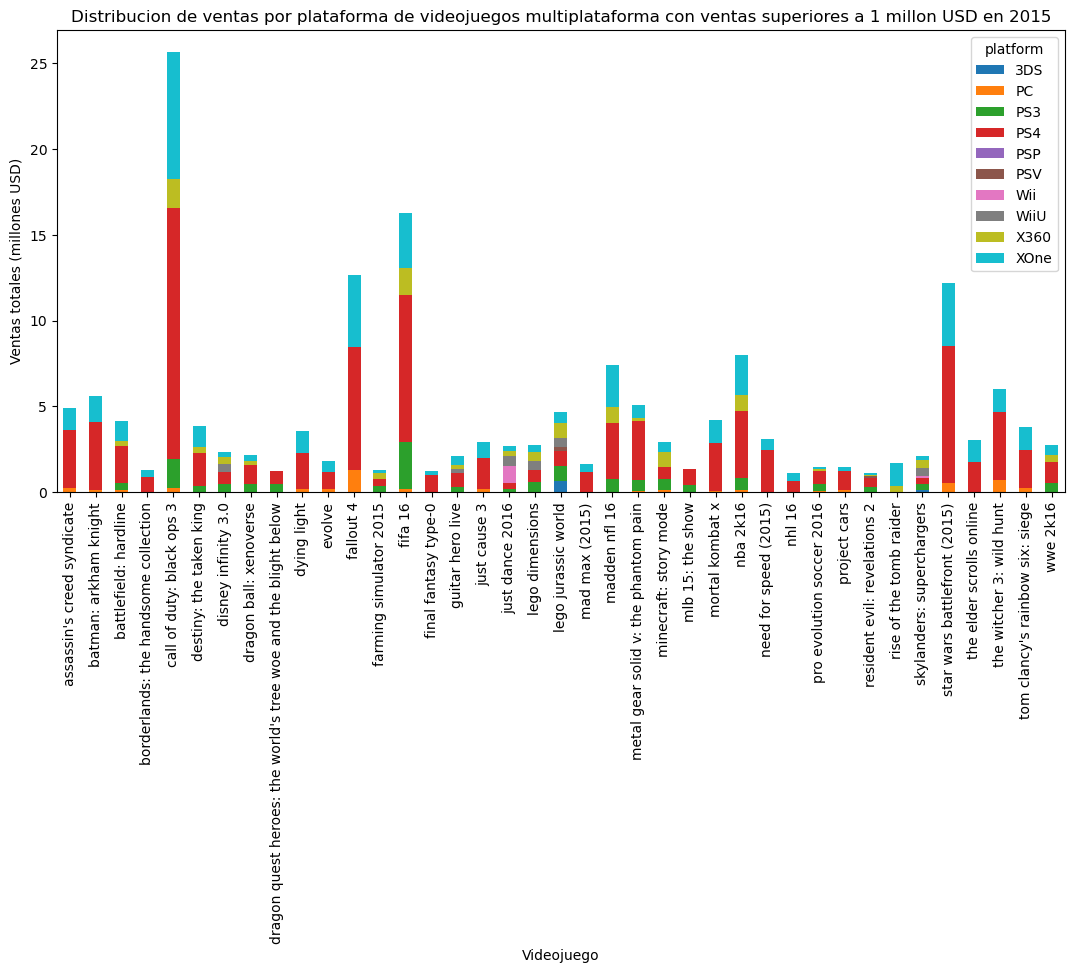

In [32]:
mplatform_games_sells_df=mplatform_games_df.groupby(['name','platform'])['total_sales'].sum().unstack(level=1)
mplatform_games_sells_df=mplatform_games_sells_df[(mplatform_games_sells_df.sum(axis=1))>1]
#mplatform_games_sells_df.sample(30)
mplatform_games_sells_df.plot(kind='bar', title='Distribucion de ventas por plataforma de videojuegos multiplataforma con ventas superiores a 1 millon USD en 2015',xlabel='Videojuego', ylabel='Ventas totales (millones USD)', stacked=True,figsize=(13,6))


Analizando la siguiente gráfica que contiene los videojuegos que son multiplataforma. La mayoria de las ventas provienen de la plataforma PS4, segudio de XOne. Las plataformas PS3 y X360 que anteriormente vimos que ya no generan tantas ventas en general, aun tienen un numero de ventas considerable en los juegos multiplataforma.

### 3.3 Ventas por género y plataforma

<Axes: title={'center': 'Distribucion de ventas por género y plataforma en 2015'}, xlabel='Videojuego', ylabel='Ventas totales (millones USD)'>

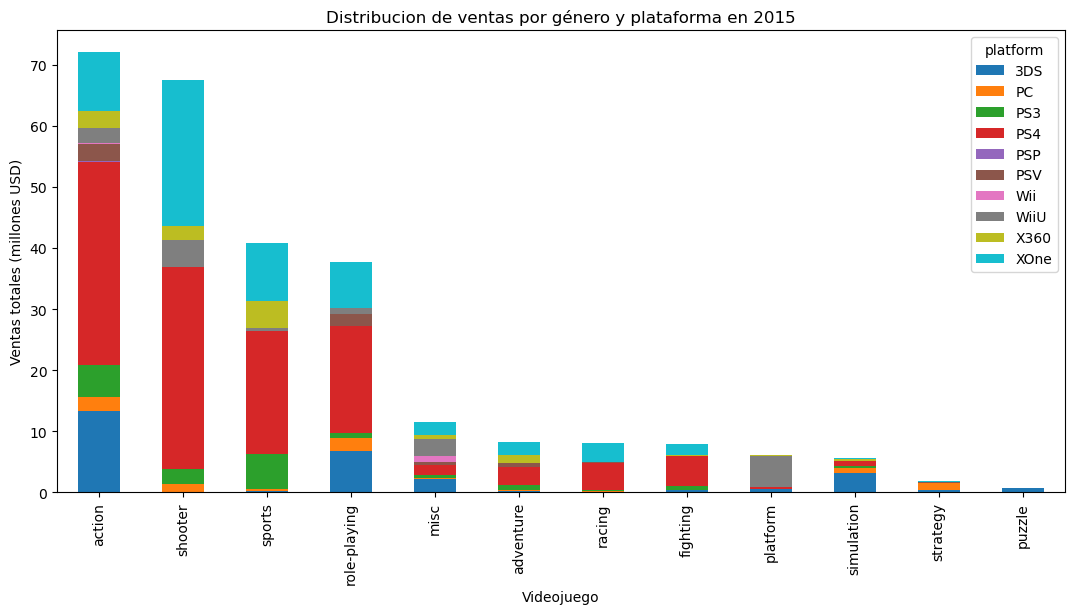

In [35]:
#genre_games_15_df=games_15_df.groupby('genre')['total_sales'].sum().reset_index().sort_values(by='total_sales',ascending=False)
genre_games_15_df=games_15_df.groupby(['genre','platform'])['total_sales'].sum().unstack(level=1)
genre_games_15_df['total_sales']=genre_games_15_df.sum(axis=1)
genre_games_15_df=genre_games_15_df.sort_values(by='total_sales',ascending=False)
genre_games_15_df=genre_games_15_df.drop(columns='total_sales')
#mplatform_games_sells_df=mplatform_games_df.groupby(['name','platform'])['total_sales'].sum().unstack(level=1)
#mplatform_games_sells_df=mplatform_games_sells_df[(mplatform_games_sells_df.sum(axis=1))>1]
#genre_games_15_df.head(12)
genre_games_15_df.plot(kind='bar', title='Distribucion de ventas por género y plataforma en 2015',xlabel='Videojuego', ylabel='Ventas totales (millones USD)', stacked=True,figsize=(13,6))


Analizando la gráfica los géneros más vendidos son los de Action, Shooter y Sports. Vemos que predominantemente la plataforma PS4 es quien lidea las ventas, seguido de XOne. Tambien podemos ver que la plataforma WiiU domina en el género platform.

## 4 Perfil de usuarios

### 4.1 Plataformas por región

In [39]:
top_platforms=['PS4','XOne','WiiU','X360','3DS']
top_games_15_df=games_15_df[games_15_df['platform'].isin(top_platforms)]
na_games_15_df=top_games_15_df.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
#na_games_15_df.head(10)
eu_games_15_df=top_games_15_df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
#eu_games_15_df.head(10)
jp_games_15_df=top_games_15_df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)
#jp_games_15_df.head(10)
ot_games_15_df=top_games_15_df.groupby('platform')['other_sales'].sum().sort_values(ascending=False)
#ot_games_15_df.head(10)

<Axes: title={'center': 'Distribucion de ventas por region y plataforma en 2015'}, xlabel='Plataforma', ylabel='Ventas totales (millones USD)'>

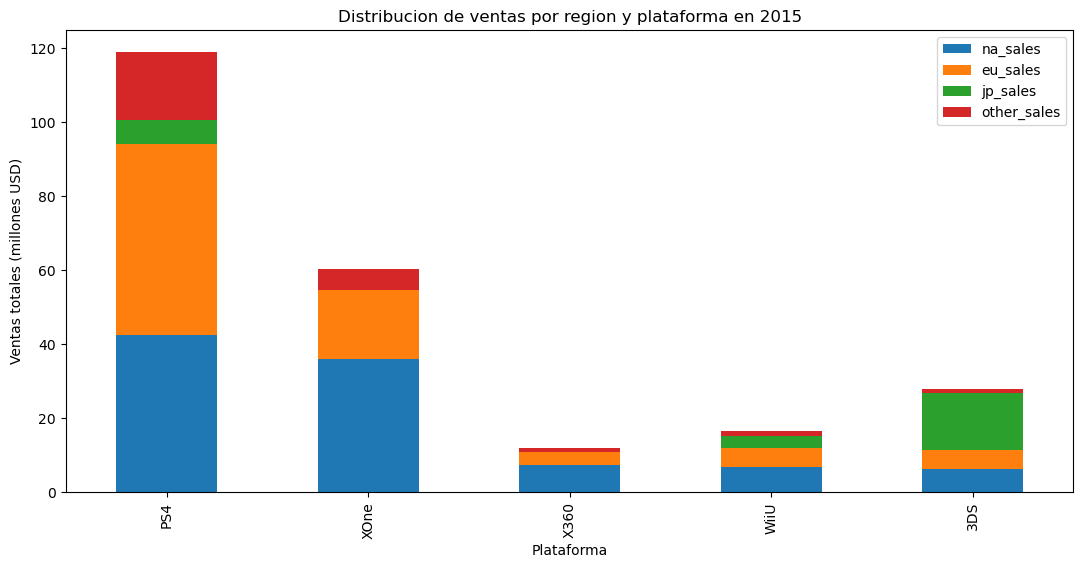

In [40]:
region_sales_15_df=pd.merge(na_games_15_df,eu_games_15_df,on='platform')
region_sales_15_df=region_sales_15_df.merge(jp_games_15_df,on='platform')
region_sales_15_df=region_sales_15_df.merge(ot_games_15_df,on='platform')
#region_sales_15_df.head()
region_sales_15_df.plot(kind='bar', title='Distribucion de ventas por region y plataforma en 2015',xlabel='Plataforma', ylabel='Ventas totales (millones USD)', stacked=True,figsize=(13,6))


Analizando la siguiente gráfica podemos notar diferentes cosas. 
*La región de NA representa bastante market share para todas las plataformas excepto en 3DS
*La región de EU y Other consumen más en la plataforma PS4
*La región de JP consume en su mayoría videojuegos de la plataforma 3DS y muy poco de las demás plataformas

### 4.2 Géneros por región

In [43]:
top_genre=['action','shooter','sports','role-playing','misc']
top_genre_games_15_df=games_15_df[games_15_df['genre'].isin(top_genre)]
na_games_15_df=top_genre_games_15_df.groupby('genre')['na_sales'].sum().sort_values(ascending=False)
#na_games_15_df.head(10)
eu_games_15_df=top_genre_games_15_df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)
#eu_games_15_df.head(10)
jp_games_15_df=top_genre_games_15_df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)
#jp_games_15_df.head(10)
ot_games_15_df=top_genre_games_15_df.groupby('genre')['other_sales'].sum().sort_values(ascending=False)
#ot_games_15_df.head(10)

<Axes: title={'center': 'Distribucion de ventas por region y género en 2015'}, xlabel='Género', ylabel='Ventas totales (millones USD)'>

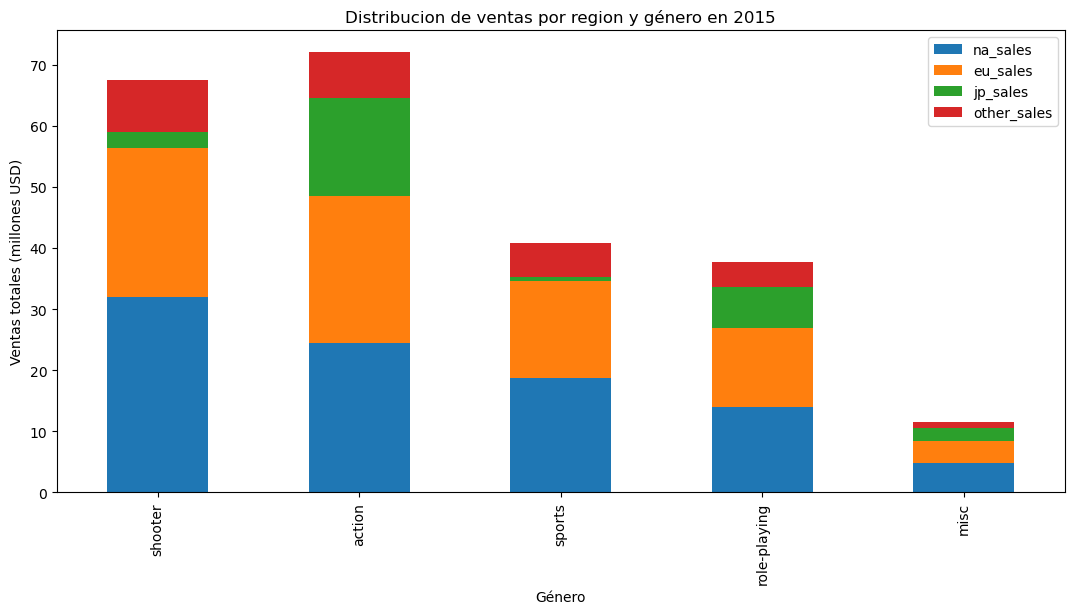

In [44]:
genre_sales_15_df=pd.merge(na_games_15_df,eu_games_15_df,on='genre')
genre_sales_15_df=genre_sales_15_df.merge(jp_games_15_df,on='genre')
genre_sales_15_df=genre_sales_15_df.merge(ot_games_15_df,on='genre')
#region_sales_15_df.head()
genre_sales_15_df.plot(kind='bar', title='Distribucion de ventas por region y género en 2015',xlabel='Género', ylabel='Ventas totales (millones USD)', stacked=True,figsize=(13,6))


Las distribuciones de ventas por género no varian considerablemente dependiendo de la región con la excepcion de la región de JP que varia con más juegos de action y de role-playing. Lo cual concuerda con los dos géneros más vendidos de 3DS y que es la plataforma más vendida en esa región.

### 4.3 Rating por región

In [47]:
games_15_df['rating'].unique()

array(['Unknown', 'E', 'M', 'T', 'E10+'], dtype=object)

In [48]:
ratings=['E','M','T','E10+']
rating_games_15_df=games_15_df[games_15_df['rating'].isin(ratings)]
na_games_15_df=rating_games_15_df.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
#na_games_15_df.head(10)
eu_games_15_df=rating_games_15_df.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
#eu_games_15_df.head(10)
jp_games_15_df=rating_games_15_df.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)
#jp_games_15_df.head(10)
ot_games_15_df=rating_games_15_df.groupby('rating')['other_sales'].sum().sort_values(ascending=False)

<Axes: title={'center': 'Distribucion de ventas por region y clasificación en 2015'}, xlabel='Clasificiación (rating)', ylabel='Ventas totales (millones USD)'>

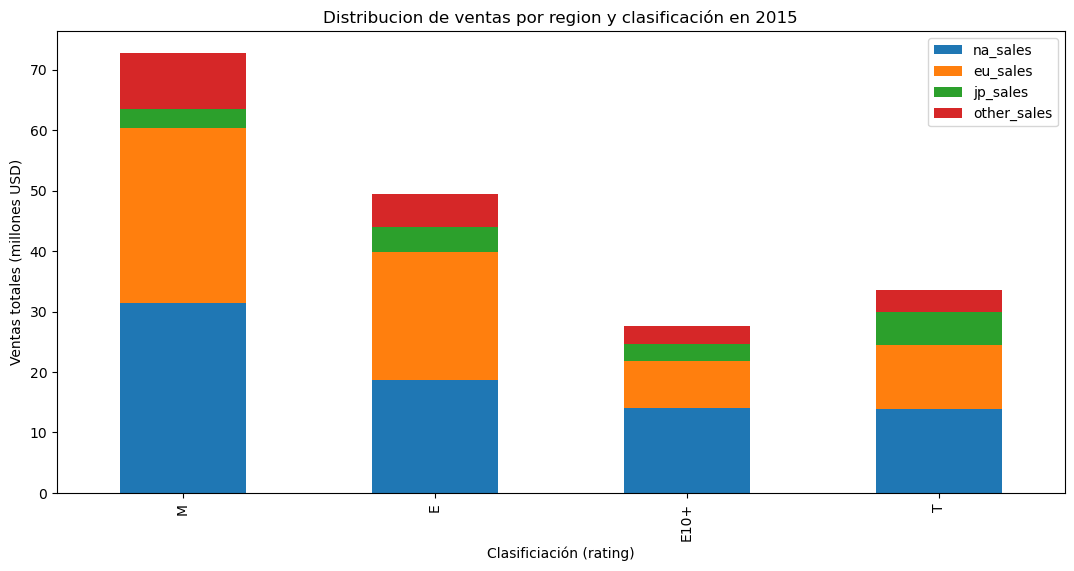

In [49]:
rating_sales_15_df=pd.merge(na_games_15_df,eu_games_15_df,on='rating')
rating_sales_15_df=rating_sales_15_df.merge(jp_games_15_df,on='rating')
rating_sales_15_df=rating_sales_15_df.merge(ot_games_15_df,on='rating')

## Eliminaremos la fila 'Unknown' porque varia bastante con las demás clasificaciones y no sabemos si esos juegos pertenecen a una de las clasificaciones.

#region_sales_15_df.head()
rating_sales_15_df.plot(kind='bar', title='Distribucion de ventas por region y clasificación en 2015',xlabel='Clasificiación (rating)', ylabel='Ventas totales (millones USD)', stacked=True,figsize=(13,6))


Analizando la gráfica podemos ver que los juegos de clasificación M son los más vendidos, pero el market share por región es casi el mismo entre todas las clasificaciones.

## 5 Prueba de hipótesis

Vamos a probar si las calificaciones promedio de los usuarios de XOne y de PC son iguales (h0) o son diferentes las calificaciones de los usuarios de XOne y PC (h1)

Primero estableceremos si las varianzas son similares o no con una prueba de levene

In [53]:
xone_games_15_df=games_15_df[games_15_df['platform']=='XOne']
pc_games_15_df=games_15_df[games_15_df['platform']=='PC']
pc_games_15_df.head(10)

stat,p_value=st.levene(xone_games_15_df['user_score'],pc_games_15_df['user_score'],nan_policy='omit')
print (f'Estadistico de Levene: {stat}')
print (f'Valor p: {p_value}')

if p_value < 0.05:
    print("Las varianzas difieren significativamente")
else:
    print("Las varianzas son similares")

Estadistico de Levene: 2.9725090541303127
Valor p: 0.08804910352011815
Las varianzas son similares


In [54]:
alpha = 0.05  
results = st.ttest_ind(xone_games_15_df['user_score'], pc_games_15_df['user_score'],equal_var=True,nan_policy='omit') 
print('valor p: ', results.pvalue) 
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p:  0.585220163714934
No podemos rechazar la hipótesis nula


La hipotesis nula no se puede rechazar ya que no difieren significativamente los promedios de calificaciones de los usuarios. Por lo que podemos decir que no influye si un juego sale para una u otra plataforma para que lo califiquen mejor o peor.

Vamos a probar si las calificaciones promedio de los usuarios del género accion y deportes son iguales (h0) o son diferentes las calificaciones de los usuarios del genero accion y deportes (h1)

Primero estableceremos si las varianzas son similares o no con una prueba de levene

In [57]:
action_games_15_df=games_15_df[games_15_df['genre']=='action']
sports_games_15_df=games_15_df[games_15_df['genre']=='sports']

stat,p_value=st.levene(action_games_15_df['user_score'],sports_games_15_df['user_score'],nan_policy='omit')
print (f'Estadistico de Levene: {stat}')
print (f'Valor p: {p_value}')

if results.pvalue < 0.05:
    print("Las varianzas difieren significativamente")
else:
    print("Las varianzas son similares")

Estadistico de Levene: 18.944978202304938
Valor p: 2.4680456812624312e-05
Las varianzas son similares


In [58]:
alpha = 0.05  
results = st.ttest_ind(action_games_15_df['user_score'], sports_games_15_df['user_score'],equal_var=True,nan_policy='omit') 
print('valor p: ', results.pvalue) 
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p:  5.954050662075536e-12
Rechazamos la hipótesis nula


In [59]:
mean_action=action_games_15_df['user_score'].mean()
mean_sports=sports_games_15_df['user_score'].mean()
print(f'El promedio de calificación para el género de acción es de: {mean_action}')
print(f'El promedio de calificación para el género de deportes es de: {mean_sports}')

El promedio de calificación para el género de acción es de: 6.941666666666666
El promedio de calificación para el género de deportes es de: 5.006666666666667


La hipotesis nula se rechaza, ya que si son significativamente diferentes los promedios de las calificaciones de los usuarios para los géneros de accion y deportes. Viendo sus promedios podemos ver que el género de acción es mejor calificado que el de deportes en general.

## 6 Conclusiones

Despues de haber analizado todos los datos estamos listos para planear una campaña. Si lo que buscamos es que le asignemos un presupuesto de marketing para generar más ventas, podriamos asignarselo a la plataforma PS4, ya que es la consola que va en crecimiento y la cual nos puede dar más ventas en las regiones de NA, EU y otras. Tambien podriamos ponerle más publicidad a los juegos que son del género Acción con clasificacion M. 

Por otro lado para la región de JP podriamos tener una campaña diferente, ya que la plataforma 3DS es la que mejor se vende en esta región. Los juegos que son de Acción es a los que más publicidad se les podria poner para que den más ventas.

Estos son las conclusiones más importantes que podemos decir con estos datos. Sin embargo si en algun momento nos llegasen a preguntar por algún juego en particular, ya sabremos cuales son sus probabilidades de éxito en ventas o no y dar una recomendación con base en nuestros datos.